# GBM Discussion

## Import Libraries:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# 为显示中文
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']

D:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Program Files\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load Data

In [2]:
# all the features with target
df_train_test = pd.read_csv("total_feat_train.csv",index_col="个人编码")
# 所有特征
features = df_train_test.columns.difference(['target'])

In [3]:
model1_feat = pd.read_csv("model1_features.csv",index_col=0).index.unique()
model1_feat_apply = pd.read_csv("model1_feat_imp.csv",index_col=0,header=None).index
model2_feat = pd.read_csv("model2_features.csv",header=None).set_index(1).index.unique()
model2_feat_apply = pd.read_csv("model2_feat_imp.csv",index_col=0,header=None).index
predictors = model1_feat.union(model2_feat)

In [1]:
# 去除重复特征
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []
    for t, v in groups.items():
        dcols = frame[v].to_dict(orient="list")

        vs = dcols.values()
        ks = dcols.keys()
        lvs = len(vs)

        for i in range(lvs):
            for j in range(i+1,lvs):
                if vs[i] == vs[j]: 
                    dups.append(ks[i])
                    break

    return dups

dups = duplicate_columns(df_train_test[predictors])

NameError: name 'df_train_test' is not defined

In [4]:
# Using 896feature
#predictors = predictors.difference(dups)
#predictors = predictors.difference(["first_time"])

# Using the 3000+features?
dups = duplicate_columns(df_train_test[features])
predictors = features.difference(dups)
                                       
target = 'target'

In [10]:
dups = df_train_test.columns[(df_train_test.columns.str.startswith('every_period'))&(df_train_test.columns.str.endswith('.1'))]

In [11]:
df_train_test = df_train_test.drop(dups,axis=1)

In [12]:
# 构建特征，以区别未提供疾病信息和提供了疾病信息的个人；未知未
df_train_test["disease_known_unknown"]=df_train_test["disease_未知"]/(df_train_test["trans_stat_sum"])
df_train_test["service_known_unknown"]=df_train_test["service_未知"]/(df_train_test["trans_stat_sum"])

In [14]:
df_train_test.to_csv("total_feat_train_latest.csv")

In [15]:
predictors = df_train_test.columns.difference(['first_time','last_time','target'])

In [16]:
df_train_test['target'].value_counts()

0    19000
1     1000
Name: target, dtype: int64

In [8]:
predictors

Index([u'day_to_nhospitals', u'dayofweek_0', u'dayofweek_1', u'dayofweek_2',
       u'dayofweek_3', u'dayofweek_4', u'dayofweek_5', u'dayofweek_6',
       u'disease_Ⅱ', u'disease_不耐受',
       ...
       u'非账户支付金额_q1', u'非账户支付金额_q2', u'非账户支付金额_q3', u'非账户支付金额_std',
       u'非账户支付金额_sum', u'高价材料发生金额_max', u'高价材料发生金额_mean', u'高价材料发生金额_q3',
       u'高价材料发生金额_std', u'高价材料发生金额_sum'],
      dtype='object', length=896)

## Spliting Data

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
idx_train, idx_test = ss.split(df_train_test[predictors],df_train_test[target]).next()
print 'train: ',len(idx_train)
print 'test: ',len(idx_test)
print 'ratio',float(len(idx_test))/(len(idx_train)+len(idx_test))

train:  16000
test:  4000
ratio 0.2


In [18]:
df_train = df_train_test.iloc[idx_train,:]
df_test = df_train_test.iloc[idx_test,:]

## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. perform CV is performCV is True
6. plot Feature Importance if printFeatureImportance is True

In [19]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Training:"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target], dtrain_predictions)
    print "F1 Score : %f" % metrics.f1_score(dtrain[target],dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target],dtrain_predprob)
    print "Classification Report : \n", metrics.classification_report(dtrain[target],dtrain_predictions)
    print ""
    
    # predict on testing data:
    print "Testing: "
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    print "Accuracy : %.4g" % metrics.accuracy_score(dtest[target], dtest_predictions)
    print "F1 Score : %f" % metrics.f1_score(dtest[target],dtest_predictions)
    print 'AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target], dtest_predprob)
    print "Classification Report : \n", metrics.classification_report(dtest[target],dtest_predictions)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp[:60].plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    return feat_imp

## Baseline Model

Since here the criteria is AUC, simply predicting the most prominent class would give an AUC of 0.5 always. Another way of getting a baseline model is to use the algorithm without tuning, i.e. with default parameters.


Model Report
Training:
Accuracy : 0.9683
F1 Score : 0.557977
AUC Score (Train): 0.964733
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     15200
          1       0.92      0.40      0.56       800

avg / total       0.97      0.97      0.96     16000


Testing: 
Accuracy : 0.9647
F1 Score : 0.515464
AUC Score (Test): 0.905767
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3800
          1       0.82      0.38      0.52       200

avg / total       0.96      0.96      0.96      4000

CV Score : Mean - 0.9001094 | Std - 0.006632202 | Min - 0.8908049 | Max - 0.9088158


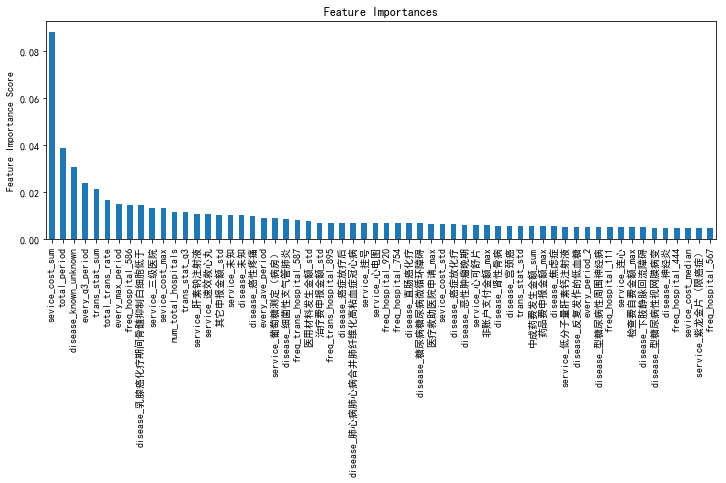

In [20]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
feat_imp = modelfit(gbm0, df_train, df_test, predictors)

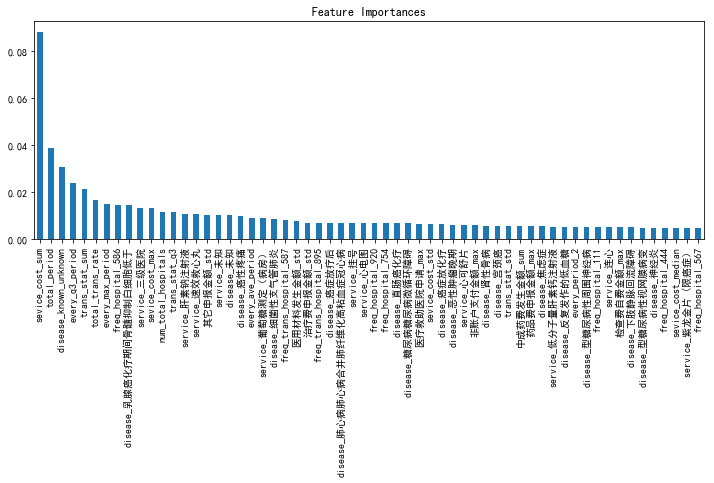

In [21]:
feat_imp[:60].plot(kind='bar', title='Feature Importances')

In [23]:
feat_imp[feat_imp!=0].size

261

## GBM Models:

There 2 types of parameters here:
1. Tree-specific parameters
  * min_samples_split
  * min_samples_leaf
  * max_depth
  * min_leaf_nodes
  * max_features
  * loss function
2. Boosting specific paramters
  * n_estimators
  * learning_rate
  * subsample

## Approach for tackling the problem

1. Decide a relatively higher value for learning rate and tune the number of estimators requried for that.
2. Tune the tree specific parameters for that learning rate
3. Tune subsample
4. Lower learning rate as much as possible computationally and increase the number of estimators accordingly.

## Step 1- Find the number of estimators for a high learning rate

We will use the following benchmarks for parameters:
1. min_samples_split = 500 : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value
2. min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.
3. max_depth = 8 : since high number of observations and predictors, choose relatively high value
4. max_features = 'sqrt' : general thumbrule to start with
5. subsample = 0.8 : typically used value (will be tuned later)

0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.

In [5]:
import math
100/math.sqrt(100)
math.sqrt(605)/605

0.040655781409087086

In [28]:
#Choose all predictors except target & IDcols
import time
time_start = time.time()

param_test1 = {'n_estimators':range(60,91,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])

time_end = time.time()
print "Total Time Cost：", (time_end-time_start)/60.,"min."

Total Time Cost： 1.77004999717 min.


In [29]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.90774, std: 0.00936, params: {'n_estimators': 60},
  mean: 0.91013, std: 0.00915, params: {'n_estimators': 70},
  mean: 0.91159, std: 0.00958, params: {'n_estimators': 80},
  mean: 0.91295, std: 0.00874, params: {'n_estimators': 90}],
 {'n_estimators': 90},
 0.9129547697368421)

So we got 130 as the optimal estimators for the 0.1 learning rate. Note that 60 is a reasonable value and can be used as it is. But it might not be the same in all cases. Other situations:
1. If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search
2. If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate

## Step 2- Tune tree-specific parameters
Now, lets move onto tuning the tree parameters. We will do this in 2 stages:
1. Tune max_depth and num_samples_split
2. Tune min_samples_leaf
3. Tune max_features

In [30]:
#Grid seach on subsample and max_features
time_start = time.time()

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(50,221,50)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_train[predictors],df_train[target])

time_end = time.time()
print "Total Time Cost：", (time_end-time_start)/60,"min."

Total Time Cost： 10.9820166667 min.


In [31]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.89092, std: 0.01257, params: {'min_samples_split': 50, 'max_depth': 5},
  mean: 0.89666, std: 0.00642, params: {'min_samples_split': 100, 'max_depth': 5},
  mean: 0.89730, std: 0.00983, params: {'min_samples_split': 150, 'max_depth': 5},
  mean: 0.89471, std: 0.00973, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.89461, std: 0.01558, params: {'min_samples_split': 50, 'max_depth': 7},
  mean: 0.89613, std: 0.01297, params: {'min_samples_split': 100, 'max_depth': 7},
  mean: 0.89131, std: 0.01445, params: {'min_samples_split': 150, 'max_depth': 7},
  mean: 0.89492, std: 0.00960, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.89842, std: 0.00486, params: {'min_samples_split': 50, 'max_depth': 9},
  mean: 0.89871, std: 0.00830, params: {'min_samples_split': 100, 'max_depth': 9},
  mean: 0.89608, std: 0.00960, params: {'min_samples_split': 150, 'max_depth': 9},
  mean: 0.89554, std: 0.01289, params: {'min_samples_split': 200, 'max_depth': 9},
  mean:

In [32]:
#Grid seach on subsample and max_features
time_start = time.time()

param_test2b = {'min_samples_split':range(20,110,10),'max_depth':range(9,14,2)}
gsearch2b = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(df_train[predictors],df_train[target])

time_end = time.time()
print "Total Time Cost：", (time_end-time_start)/60,"min."

Total Time Cost： 13.314349997 min.


In [33]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.89484, std: 0.00934, params: {'min_samples_split': 20, 'max_depth': 9},
  mean: 0.89385, std: 0.01375, params: {'min_samples_split': 30, 'max_depth': 9},
  mean: 0.90109, std: 0.00698, params: {'min_samples_split': 40, 'max_depth': 9},
  mean: 0.89842, std: 0.00486, params: {'min_samples_split': 50, 'max_depth': 9},
  mean: 0.89974, std: 0.01048, params: {'min_samples_split': 60, 'max_depth': 9},
  mean: 0.89590, std: 0.00699, params: {'min_samples_split': 70, 'max_depth': 9},
  mean: 0.90332, std: 0.00774, params: {'min_samples_split': 80, 'max_depth': 9},
  mean: 0.89884, std: 0.00601, params: {'min_samples_split': 90, 'max_depth': 9},
  mean: 0.89871, std: 0.00830, params: {'min_samples_split': 100, 'max_depth': 9},
  mean: 0.90099, std: 0.01073, params: {'min_samples_split': 20, 'max_depth': 11},
  mean: 0.89845, std: 0.00653, params: {'min_samples_split': 30, 'max_depth': 11},
  mean: 0.89542, std: 0.01040, params: {'min_samples_split': 40, 'max_depth': 11},
  mean: 0.89

In [37]:
#Grid seach on subsample and max_features
time_start = time.time()

param_test2c = {'max_depth':[6,7,8,9,10]}
gsearch2c = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,
                                                min_samples_split=80,max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2c, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2c.fit(df_train[predictors],df_train[target])

time_end = time.time()
print "Total Time Cost：", (time_end-time_start)/60,"min."

Total Time Cost： 2.23403333426 min.


In [38]:
gsearch2c.grid_scores_, gsearch2c.best_params_, gsearch2c.best_score_

([mean: 0.89761, std: 0.01022, params: {'max_depth': 6},
  mean: 0.89750, std: 0.01050, params: {'max_depth': 7},
  mean: 0.89765, std: 0.00764, params: {'max_depth': 8},
  mean: 0.90332, std: 0.00774, params: {'max_depth': 9},
  mean: 0.89689, std: 0.01309, params: {'max_depth': 10}],
 {'max_depth': 9},
 0.9033162006578948)

Since we reached the maximum of min_sales_split, we should check higher values as well. Also, we can tune min_samples_leaf with it now as max_depth is fixed. One might argue that max depth might change for higher value but if you observe the output closely, a max_depth of 9 had a better model for most of cases.
So lets perform a grid search on them:

In [39]:
#Grid seach on subsample and max_features
param_test3 = {'min_samples_leaf': range(5,60,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,max_depth=9,
                                                   min_samples_split=80,max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=80, min_weight_fraction_leaf=0.0,
              n_estimators=90, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [5, 15, 25, 35, 45, 55]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [40]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.90483, std: 0.00555, params: {'min_samples_leaf': 5},
  mean: 0.90257, std: 0.01019, params: {'min_samples_leaf': 15},
  mean: 0.90715, std: 0.01082, params: {'min_samples_leaf': 25},
  mean: 0.91215, std: 0.00905, params: {'min_samples_leaf': 35},
  mean: 0.91126, std: 0.01599, params: {'min_samples_leaf': 45},
  mean: 0.91270, std: 0.01337, params: {'min_samples_leaf': 55}],
 {'min_samples_leaf': 55},
 0.9126994243421052)

In [42]:
#Grid seach on subsample and max_features
param_test3b = {'min_samples_leaf': [45,50,55,60,65]}
gsearch3b = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,max_depth=9,
                                                   min_samples_split=80,max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3b.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=80, min_weight_fraction_leaf=0.0,
              n_estimators=90, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [5, 15, 25, 35, 45, 55]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [43]:
gsearch3b.grid_scores_, gsearch3b.best_params_, gsearch3b.best_score_

([mean: 0.90483, std: 0.00555, params: {'min_samples_leaf': 5},
  mean: 0.90257, std: 0.01019, params: {'min_samples_leaf': 15},
  mean: 0.90715, std: 0.01082, params: {'min_samples_leaf': 25},
  mean: 0.91215, std: 0.00905, params: {'min_samples_leaf': 35},
  mean: 0.91126, std: 0.01599, params: {'min_samples_leaf': 45},
  mean: 0.91270, std: 0.01337, params: {'min_samples_leaf': 55}],
 {'min_samples_leaf': 55},
 0.9126994243421052)


Model Report
Training:
Accuracy : 0.9839
F1 Score : 0.808605
AUC Score (Train): 0.996115
Classification Report : 
             precision    recall  f1-score   support

          0       0.98      1.00      0.99     15200
          1       0.99      0.68      0.81       800

avg / total       0.98      0.98      0.98     16000


Testing: 
Accuracy : 0.9633
F1 Score : 0.505051
AUC Score (Test): 0.920136
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3800
          1       0.77      0.38      0.51       200

avg / total       0.96      0.96      0.96      4000

CV Score : Mean - 0.9126994 | Std - 0.01336867 | Min - 0.8943729 | Max - 0.9350596


total_period                              0.021476
service_未知                                0.020999
sevice_cost_sum                           0.016584
every_q3_period                           0.015979
every_ave_period                          0.015941
disease_未知                                0.015024
disease_known_unknown                     0.013568
三目统计项目_sum                                0.010851
trans_stat_sum                            0.010561
total_rate                                0.010422
药品费自费金额_sum                               0.009979
every_max_period                          0.009353
可用账户报销金额_sum                              0.009341
起付标准以上自负比例金额_std                          0.009336
num_total_hospitals                       0.008860
every_period_2                            0.008619
起付标准以上自负比例金额_max                          0.008468
药品费申报金额_max                               0.008382
total_trans_rate                          0.008270
本次审批金额_max                     

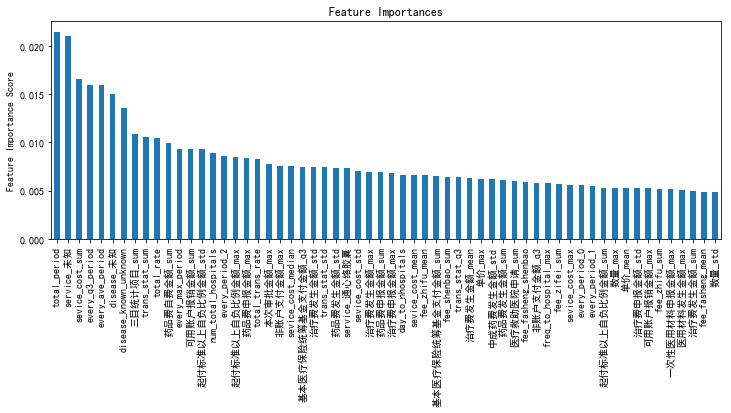

In [44]:
modelfit(gsearch3.best_estimator_, df_train, df_test, predictors)

Tune max_features:

In [45]:
feat_imp.size

3619

In [46]:
sqrt(3619)

60.158124970780129

In [49]:
#Grid seach on subsample and max_features
param_test4 = {'max_features':range(55,80,5)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,max_depth=9,
                                                   min_samples_leaf=35,min_samples_split=80,max_features='sqrt', subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=35,
              min_samples_split=80, min_weight_fraction_leaf=0.0,
              n_estimators=90, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [55, 60, 65, 70, 75]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [50]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.91006, std: 0.01074, params: {'max_features': 55},
  mean: 0.91215, std: 0.00905, params: {'max_features': 60},
  mean: 0.91173, std: 0.01486, params: {'max_features': 65},
  mean: 0.91063, std: 0.01229, params: {'max_features': 70},
  mean: 0.90853, std: 0.01313, params: {'max_features': 75}],
 {'max_features': 60},
 0.912145148026316)

## Step3- Tune Subsample and Lower Learning Rate

In [51]:
#Grid seach on subsample and max_features
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=90,max_depth=9,
                                                   min_samples_leaf=35,min_samples_split=80,
                                                    subsample=0.8, random_state=10,max_features=60),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(df_train[predictors],df_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=9,
              max_features=60, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=35,
              min_samples_split=80, min_weight_fraction_leaf=0.0,
              n_estimators=90, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [52]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.90896, std: 0.01039, params: {'subsample': 0.6},
  mean: 0.90861, std: 0.01428, params: {'subsample': 0.7},
  mean: 0.90984, std: 0.01370, params: {'subsample': 0.75},
  mean: 0.91215, std: 0.00905, params: {'subsample': 0.8},
  mean: 0.90746, std: 0.01427, params: {'subsample': 0.85},
  mean: 0.91060, std: 0.01298, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.912145148026316)

With all tuned lets try reducing the learning rate and proportionally increasing the number of estimators to get more robust results:


Model Report
Training:
Accuracy : 0.9895
F1 Score : 0.882682
AUC Score (Train): 0.999037
Classification Report : 
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     15200
          1       1.00      0.79      0.88       800

avg / total       0.99      0.99      0.99     16000


Testing: 
Accuracy : 0.9665
F1 Score : 0.544218
AUC Score (Test): 0.926553
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3800
          1       0.85      0.40      0.54       200

avg / total       0.96      0.97      0.96      4000

CV Score : Mean - 0.9214256 | Std - 0.01136823 | Min - 0.9051604 | Max - 0.9398047


sevice_cost_sum                       0.019418
trans_stat_sum                        0.014704
disease_known_unknown                 0.014640
service_未知                            0.014469
disease_未知                            0.013565
total_period                          0.012477
num_total_hospitals                   0.011818
total_rate                            0.011812
every_ave_period                      0.011550
total_trans_rate                      0.011527
every_q3_period                       0.009979
治疗费发生金额_mean                          0.008093
三目统计项目_sum                            0.007584
every_max_period                      0.007138
本次审批金额_sum                            0.007069
every_period_2                        0.006979
sevice_cost_mean                      0.006881
freq_to_hospital_max                  0.006832
sevice_cost_max                       0.006690
非账户支付金额_q1                            0.006460
治疗费发生金额_sum                           0.006395
基本医疗保险统筹基金支付金

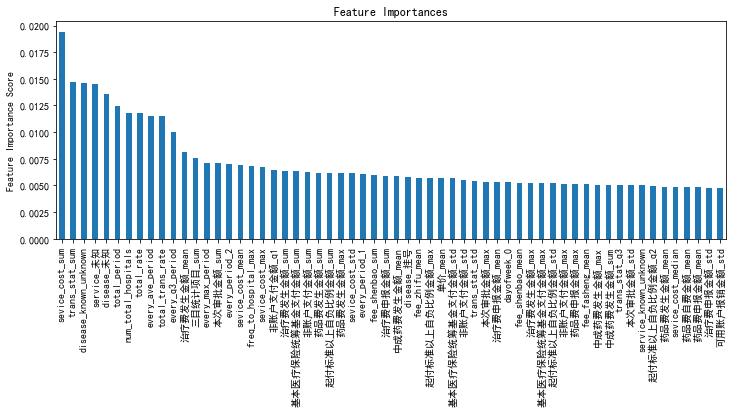

In [53]:
#Choose all predictors except target & IDcols
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=270,max_depth=9,
                                                   min_samples_leaf=35,min_samples_split=80,
                                                    subsample=0.8, random_state=10,max_features=60)
modelfit(gbm_tuned_1, df_train, df_test, predictors)

1/10th learning rate


Model Report
Training:
Accuracy : 0.9886
F1 Score : 0.871650
AUC Score (Train): 0.999016
Classification Report : 
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     15200
          1       1.00      0.77      0.87       800

avg / total       0.99      0.99      0.99     16000


Testing: 
Accuracy : 0.9663
F1 Score : 0.532872
AUC Score (Test): 0.929833
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3800
          1       0.87      0.39      0.53       200

avg / total       0.96      0.97      0.96      4000

CV Score : Mean - 0.9257734 | Std - 0.01027205 | Min - 0.910882 | Max - 0.9431867


sevice_cost_sum                        0.022036
trans_stat_sum                         0.015293
disease_known_unknown                  0.013641
disease_未知                             0.012592
total_period                           0.012492
every_ave_period                       0.012058
total_trans_rate                       0.011908
service_未知                             0.011330
total_rate                             0.010585
num_total_hospitals                    0.010450
every_q3_period                        0.010170
三目统计项目_sum                             0.008817
every_max_period                       0.008537
freq_to_hospital_max                   0.007713
sevice_cost_mean                       0.007066
fee_fasheng_mean                       0.006934
本次审批金额_sum                             0.006880
every_period_2                         0.006817
fee_shenbao_sum                        0.006592
trans_stat_mean                        0.006519
fee_zhifu_mean                         0

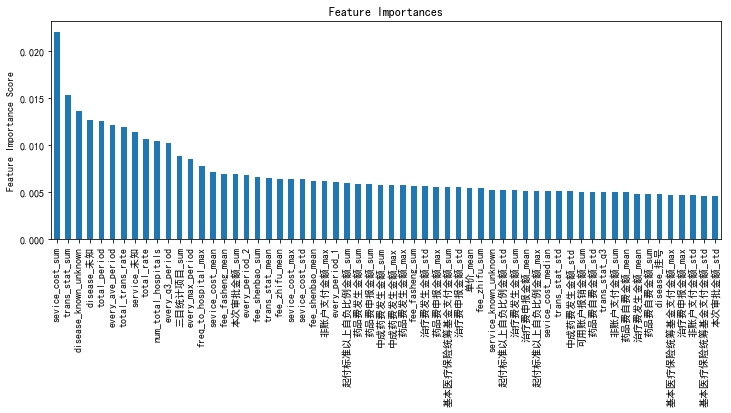

In [54]:
#Choose all predictors except target & IDcols
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=90*15,max_depth=9,
                                                   min_samples_leaf=35,min_samples_split=80,
                                                    subsample=0.8, random_state=10,max_features=60)
modelfit(gbm_tuned_2, df_train, df_test, predictors)

1/50th learning rate


Model Report
Training:
Accuracy : 0.9932
F1 Score : 0.926895
AUC Score (Train): 0.999782
Classification Report : 
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     15200
          1       1.00      0.86      0.93       800

avg / total       0.99      0.99      0.99     16000


Testing: 
Accuracy : 0.963
F1 Score : 0.463768
AUC Score (Test): 0.937908
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3800
          1       0.84      0.32      0.46       200

avg / total       0.96      0.96      0.95      4000



sevice_cost_sum              0.025823
disease_未知                   0.012476
trans_stat_sum               0.011925
total_rate                   0.011892
every_ave_period             0.011543
service_未知                   0.011403
num_total_hospitals          0.011318
total_period                 0.011112
total_trans_rate             0.010507
every_q3_period              0.010020
三目统计项目_sum                   0.009038
every_period_1               0.007970
非账户支付金额_max                  0.007696
freq_to_hospital_max         0.007515
last_time                    0.007513
every_max_period             0.007374
sevice_cost_std              0.006755
trans_stat_mean              0.006632
sevice_cost_mean             0.006512
sevice_cost_max              0.006361
disease_挂号                   0.006193
起付标准以上自负比例金额_sum             0.006189
fee_shenbao_mean             0.006081
fee_shenbao_sum              0.006046
trans_stat_q3                0.005996
药品费申报金额_max                  0.005946
fee_fasheng_

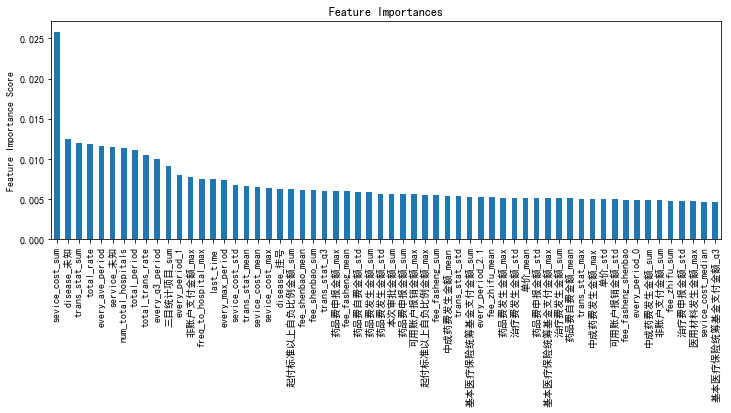

In [88]:
#Choose all predictors except target & IDcols
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=2600, max_depth=9, 
                            min_samples_split=60, min_samples_leaf=25, subsample=0.8, random_state=10, max_features=28,
                                         warm_start=True)
modelfit(gbm_tuned_3, df_train, df_test, predictors, performCV=False)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.906346


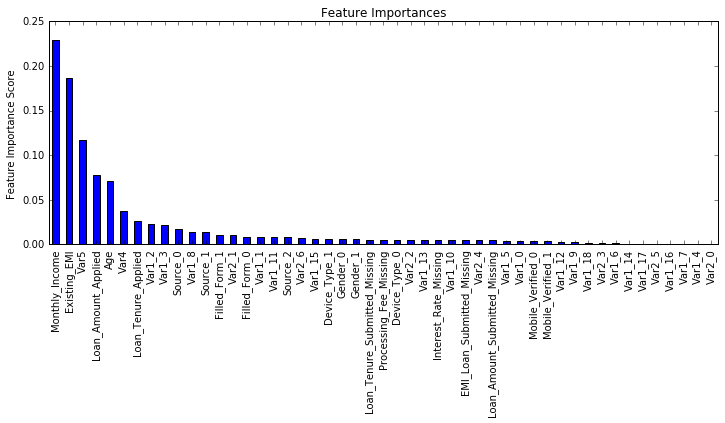

In [46]:
#Choose all predictors except target & IDcols
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
                                         warm_start=True)
modelfit(gbm_tuned_4, df_train, df_test, predictors, performCV=False)

# Model Analysis

## Training and Predicting

In [89]:
# model1 using selected features
gbdt = GradientBoostingClassifier(learning_rate=0.005, n_estimators=2600,max_depth=9, 
                            min_samples_split=60, min_samples_leaf=25, subsample=0.8,
                                  random_state=10, max_features=28)
gbdt.fit(df_train[predictors],df_train[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=9,
              max_features=28, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=25,
              min_samples_split=60, min_weight_fraction_leaf=0.0,
              n_estimators=2600, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False)

In [55]:
# model2 using all the features
gbdt=GradientBoostingClassifier(learning_rate=0.01, n_estimators=90*15,max_depth=9,
                                        min_samples_leaf=35,min_samples_split=80,
                                            subsample=0.8, random_state=10,max_features=60)
gbdt.fit(df_train[predictors],df_train[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=9,
              max_features=60, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=35,
              min_samples_split=80, min_weight_fraction_leaf=0.0,
              n_estimators=1350, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False)

Accuracy : 0.9663
F1 Score : 0.532872
AUC Score (Test): 0.929833
Classification Report : 
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3800
          1       0.87      0.39      0.53       200

avg / total       0.96      0.97      0.96      4000



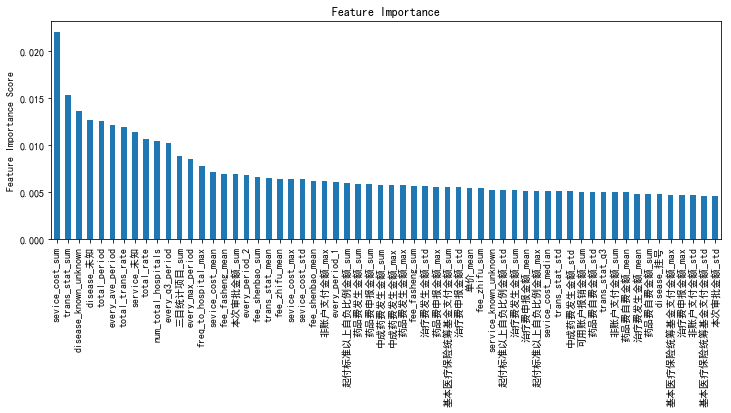

In [56]:
# predict on testing data:
df_test_predictions = gbdt.predict(df_test[predictors])
df_test_predprob = gbdt.predict_proba(df_test[predictors])[:,1]

print "Accuracy : %.4g" % metrics.accuracy_score(df_test[target], df_test_predictions)
print "F1 Score : %f" % metrics.f1_score(df_test[target],df_test_predictions)
print 'AUC Score (Test): %f' % metrics.roc_auc_score(df_test[target], df_test_predprob)
print "Classification Report : \n", metrics.classification_report(df_test[target],df_test_predictions)

rcParams['figure.figsize'] = 12,4
feat_imp = pd.Series(gbdt.feature_importances_,index=predictors).sort_values(ascending=False)
feat_imp[0:60].plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

## Confusion Matrix

In [57]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.ion()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1 score:  0.532871972318
Recall metric in testing dataset:  0.385


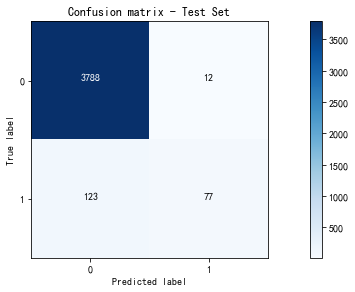

In [58]:
print "F1 score: ", metrics.f1_score(df_test[target], df_test_predictions)

# confusion matrix
cnf_matrix = confusion_matrix(df_test[target], df_test_predictions)
np.set_printoptions(precision=2)

print "Recall metric in testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1])

# plot non_normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title='Confusion matrix - Test Set')
plt.show()

## ROC

D:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


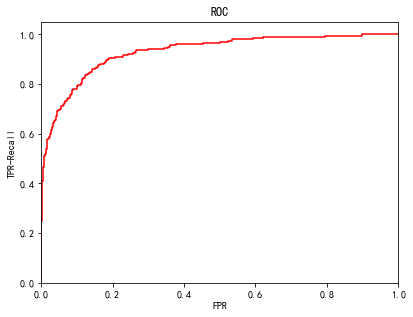

In [59]:
from sklearn.metrics import roc_curve, auc
rcParams['figure.figsize'] = 6.4,4.8
#df_test_predictions = xgb.predict(dtest[predictors])
#df_test_predprob = xgb.predict_proba(dtest[predictors])[:,1]
fpr, tpr, thresholds = roc_curve(df_test[target].values,df_test_predprob)
# Plot Precision-Recall curve
plt.plot(fpr, tpr, color='r')
plt.xlabel('FPR')
plt.ylabel('TPR-Recall')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC')
plt.legend()

## Precision-Recall curve

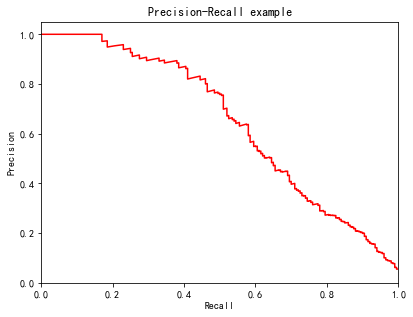

In [60]:
from sklearn.metrics import precision_recall_curve
rcParams['figure.figsize'] = 6.4,4.8
precision, recall, thresholds = precision_recall_curve(df_test[target].values,df_test_predprob)
# Plot Precision-Recall curve
plt.plot(recall, precision, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example')
plt.legend()

# Optimization: Changing Threshold

## Precision and Recall

Threshold:  0.1 , F1 score: [ 0.1   0.53  0.  ]
[ 0.05  0.43  1.  ] [ 1.    0.69  0.  ] [False  True]
Threshold:  0.2 , F1 score: [ 0.1  0.6  0. ]
[ 0.05  0.61  1.  ] [ 1.    0.58  0.  ] [False  True]
Threshold:  0.3 , F1 score: [ 0.1   0.59  0.  ]
[ 0.05  0.77  1.  ] [ 1.    0.48  0.  ] [False  True]
Threshold:  0.4 , F1 score: [ 0.1   0.55  0.  ]
[ 0.05  0.82  1.  ] [ 1.    0.41  0.  ] [False  True]
Threshold:  0.5 , F1 score: [ 0.1   0.53  0.  ]
[ 0.05  0.87  1.  ] [ 1.    0.39  0.  ] [False  True]
Threshold:  0.6 , F1 score: [ 0.1  0.5  0. ]
[ 0.05  0.89  1.  ] [ 1.    0.35  0.  ] [False  True]
Threshold:  0.7 , F1 score: [ 0.1   0.43  0.  ]
[ 0.05  0.9   1.  ] [ 1.    0.28  0.  ] [False  True]
Threshold:  0.8 , F1 score: [ 0.1   0.38  0.  ]
[ 0.05  0.94  1.  ] [ 1.    0.24  0.  ] [False  True]
Threshold:  0.9 , F1 score: [ 0.1   0.28  0.  ]
[ 0.05  1.    1.  ] [ 1.    0.17  0.  ] [False  True]


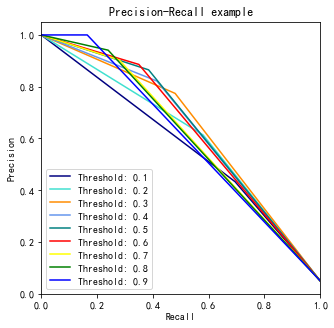

In [61]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve

#df_test_predictions = xgb.predict(df_test[predictors])
df_test_predprob = gbdt.predict_proba(df_test[predictors])[:,1]

thresholds = np.arange(1,10)/10.0
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = df_test_predprob > i
    
    #print "Threshold: ",i,", F1 score:", f1_score(df_test[target],y_test_predictions_prob)
    
    precision, recall, thresholds = precision_recall_curve(df_test[target],y_test_predictions_prob)
    print "Threshold: ",i,", F1 score:", 2*precision*recall/(precision+recall)
    print precision, recall, thresholds
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend()

## Confusion Matrix

Threhold >= 0.05,  F1 score:  0.416230366492
Threhold >= 0.1,  F1 score:  0.53358925144
Threhold >= 0.15,  F1 score:  0.563636363636
Threhold >= 0.2,  F1 score:  0.596401028278
Threhold >= 0.25,  F1 score:  0.592592592593
Threhold >= 0.3,  F1 score:  0.592592592593
Threhold >= 0.35,  F1 score:  0.576051779935
Threhold >= 0.4,  F1 score:  0.551495016611
Threhold >= 0.45,  F1 score:  0.552901023891


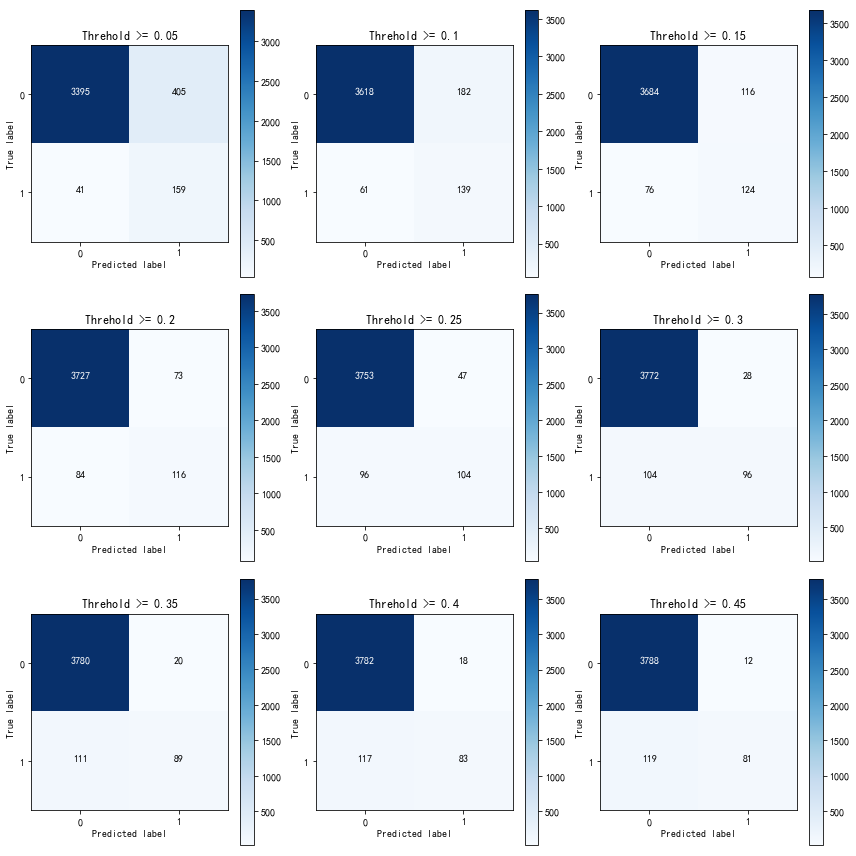

In [62]:
thresholds = np.arange(1,10)/20.0
plt.figure(figsize=(12,12))
j  = 1
for i in thresholds:
    y_test_predictions_high_recall = df_test_predprob > i
    plt.subplot(3,3,j)
    j += 1
    
    # compute confusion matrix
    cnf_matrix = confusion_matrix(df_test[target], y_test_predictions_high_recall)
    #print "Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[0,1]+cnf_matrix[1,1])
    print "Threhold >= %s, "%i,"F1 score: ", metrics.f1_score(df_test[target], y_test_predictions_high_recall)
    
    # plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix,classes=class_names,title='Threhold >= %s'%i)

## Feature Importance

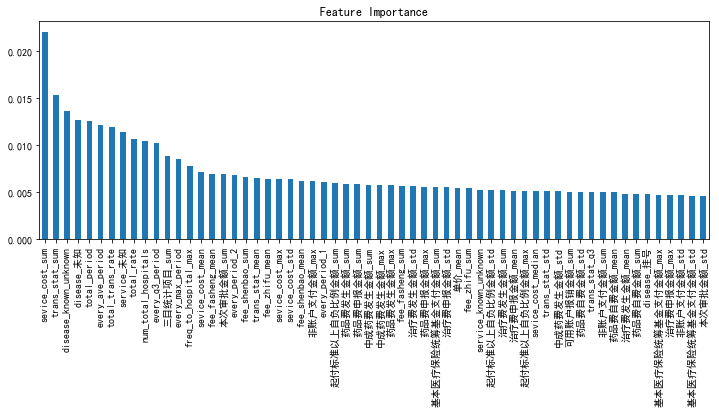

In [63]:
rcParams['figure.figsize'] = 12, 4
feat_imp[0:60].plot(kind='bar', title='Feature Importance')

In [64]:
feat_imp[feat_imp!=0].size

677

In [65]:
feat_imp[:100]

sevice_cost_sum          0.022036
trans_stat_sum           0.015293
disease_known_unknown    0.013641
disease_未知               0.012592
total_period             0.012492
every_ave_period         0.012058
total_trans_rate         0.011908
service_未知               0.011330
total_rate               0.010585
num_total_hospitals      0.010450
every_q3_period          0.010170
三目统计项目_sum               0.008817
every_max_period         0.008537
freq_to_hospital_max     0.007713
sevice_cost_mean         0.007066
fee_fasheng_mean         0.006934
本次审批金额_sum               0.006880
every_period_2           0.006817
fee_shenbao_sum          0.006592
trans_stat_mean          0.006519
fee_zhifu_mean           0.006410
sevice_cost_max          0.006387
sevice_cost_std          0.006363
fee_shenbao_mean         0.006167
非账户支付金额_max              0.006142
every_period_1           0.006011
起付标准以上自负比例金额_sum         0.005943
药品费发生金额_sum              0.005823
药品费申报金额_sum              0.005787
中成药费发生金额_sum  

In [66]:
feat = feat_imp[feat_imp!=0]

In [74]:
feat.to_csv("selected_features_latest.csv")

In [67]:
# 病种
feat.index[feat.index.str.startswith('disease')]

Index([u'disease_known_unknown', u'disease_未知', u'disease_挂号', u'disease_高血压',
       u'disease_肺原性心脏病', u'disease_肾透析', u'disease_肺心病', u'disease_冠心病',
       u'disease_慢性肺源性心脏病', u'disease_过敏性鼻炎',
       ...
       u'disease_肾病', u'disease_腹膜透析', u'disease_糖尿病糖尿病肾病',
       u'disease_糖尿病合并冠心病', u'disease_周围血管神经病变', u'disease_中风',
       u'disease_糖尿病微血管病变', u'disease_周围神经病', u'disease_糖尿病周围血管病变',
       u'disease_周围神经病变'],
      dtype='object', length=153)

In [75]:
feat_disease = pd.Series(data=feat.index[feat.index.str.startswith('disease')])

In [79]:
feat_disease.str.replace("disease_","").sort_values().to_csv("feat_disease_selected.csv")

In [80]:
# 三目服务种类
feat.index[feat.index.str.startswith('service')]

Index([u'service_未知', u'service_known_unknown', u'service_挂号',
       u'service_通心络胶囊', u'service_糖尿病门诊诊察费（门特加收）', u'service_速效救心丸',
       u'service_低分子量肝素钙注射液', u'service_肝素钠注射液', u'service_肺力咳合剂',
       u'service_多导心电图检查自动分析', u'service_低分子肝素钠注射液', u'service_牛黄清心丸',
       u'service_三级医院', u'service_地奥心血康软胶囊', u'service_脑心通胶囊',
       u'service_参松养心胶囊', u'service_通脉养心丸', u'service_依诺肝素钠注射液',
       u'service_低分子量肝素钠注射液', u'service_乙型肝炎表面抗体测定', u'service_负压采血管',
       u'service_乙型肝炎e抗原测定', u'service_乙型肝炎e抗体测定', u'service_稳心颗粒',
       u'service_乙型肝炎核心抗体测定', u'service_病床紫外线消毒', u'service_清肺消炎丸',
       u'service_肺力咳胶囊', u'service_乙型肝炎表面抗原测定', u'service_注射用低分子量肝素钠',
       u'service_主任医师挂号费', u'service_乙肝表面抗原（免疫）', u'service_副主任医师挂号费',
       u'service_肾炎康复片', u'service_乙肝表面抗体（免疫）', u'service_麝香保心丸',
       u'service_血栓心脉宁片', u'service_高压注射针筒 200', u'service_癌胚抗原（电化学发光法）',
       u'service_乙肝核心抗体', u'service_肝功能及肝血流测定', u'service_乙肝e抗体（免疫）',
       u'service_丹芪偏瘫胶囊', u'service_尿沉渣离心显

In [81]:
feat_service = pd.Series(data=feat.index[feat.index.str.startswith('service')])
feat_service.str.replace("service_","").sort_values().to_csv("feat_service_selected.csv")

In [73]:
# 时间间隔特征
feat.index[feat.index.str.startswith('every_')]

Index([u'every_ave_period', u'every_q3_period', u'every_max_period',
       u'every_period_2', u'every_period_1', u'every_period_0',
       u'every_q1_period', u'every_period_3', u'every_q2_period',
       u'every_period_4', u'every_period_7', u'every_period_19',
       u'every_min_period', u'every_period_24', u'every_period_5',
       u'every_period_14', u'every_period_16', u'every_period_17',
       u'every_period_6', u'every_period_22', u'every_period_9',
       u'every_period_18', u'every_period_13', u'every_period_8',
       u'every_period_11', u'every_period_12', u'every_period_38',
       u'every_period_10', u'every_period_15', u'every_period_23',
       u'every_period_28', u'every_period_37', u'every_period_21',
       u'every_period_27', u'every_period_20', u'every_period_29',
       u'every_period_42', u'every_period_30', u'every_period_31',
       u'every_period_40', u'every_period_32', u'every_period_25',
       u'every_period_34'],
      dtype='object')

In [82]:
feat_period = pd.Series(data=feat.index[feat.index.str.startswith('every_')])
feat_period.sort_values().to_csv("feat_period_selected.csv")

In [90]:
# 在各个医院交易频率
feat.index[feat.index.str.startswith('freq_trans_hospital_')]

Index([u'freq_trans_hospital_180', u'freq_trans_hospital_587',
       u'freq_trans_hospital_98', u'freq_trans_hospital_197',
       u'freq_trans_hospital_104', u'freq_trans_hospital_196',
       u'freq_trans_hospital_160', u'freq_trans_hospital_571',
       u'freq_trans_hospital_189', u'freq_trans_hospital_177',
       u'freq_trans_hospital_65', u'freq_trans_hospital_173',
       u'freq_trans_hospital_183', u'freq_trans_hospital_149',
       u'freq_trans_hospital_1079', u'freq_trans_hospital_24',
       u'freq_trans_hospital_190', u'freq_trans_hospital_188',
       u'freq_trans_hospital_125', u'freq_trans_hospital_115',
       u'freq_trans_hospital_567', u'freq_trans_hospital_194',
       u'freq_trans_hospital_111', u'freq_trans_hospital_30',
       u'freq_trans_hospital_145', u'freq_trans_hospital_195',
       u'freq_trans_hospital_161', u'freq_trans_hospital_141',
       u'freq_trans_hospital_1431', u'freq_trans_hospital_32',
       u'freq_trans_hospital_34', u'freq_trans_hospital_7'

In [93]:
feat_trans_hospital = pd.Series(data=feat.index[feat.index.str.startswith("freq_trans_hospital_")])
feat_trans_hospital.str.replace("freq_trans_hospital_","").sort_values().to_csv("feat_trans_hospital_selected.csv")

In [92]:
# 去各个医院的频率
feat.index[feat.index.str.startswith('freq_hospital_')]

Index([u'freq_hospital_180', u'freq_hospital_98', u'freq_hospital_104',
       u'freq_hospital_587', u'freq_hospital_173', u'freq_hospital_189',
       u'freq_hospital_177', u'freq_hospital_145', u'freq_hospital_571',
       u'freq_hospital_194', u'freq_hospital_197', u'freq_hospital_183',
       u'freq_hospital_160', u'freq_hospital_196', u'freq_hospital_149',
       u'freq_hospital_141', u'freq_hospital_24', u'freq_hospital_65',
       u'freq_hospital_34', u'freq_hospital_188', u'freq_hospital_161',
       u'freq_hospital_1079', u'freq_hospital_567', u'freq_hospital_190',
       u'freq_hospital_32', u'freq_hospital_30', u'freq_hospital_154',
       u'freq_hospital_7', u'freq_hospital_195', u'freq_hospital_170',
       u'freq_hospital_1431', u'freq_hospital_140', u'freq_hospital_125',
       u'freq_hospital_896', u'freq_hospital_934', u'freq_hospital_115',
       u'freq_hospital_444', u'freq_hospital_76', u'freq_hospital_42',
       u'freq_hospital_5', u'freq_hospital_150', u'freq_hos

In [94]:
feat_to_hospital = pd.Series(data=feat.index[feat.index.str.startswith("freq_hospital_")])
feat_to_hospital.str.replace("freq_hospital_","").sort_values().to_csv("feat_to_hospital_selected.csv")

In [99]:
feat[feat.index[feat.index.str.startswith('every_')]].sort_values(ascending=False)

every_ave_period    0.012058
every_q3_period     0.010170
every_max_period    0.008537
every_period_2      0.006817
every_period_1      0.006011
every_period_0      0.003764
every_q1_period     0.003158
every_period_3      0.003053
every_q2_period     0.002702
every_period_4      0.002277
every_period_7      0.001611
every_period_19     0.001603
every_min_period    0.001589
every_period_24     0.001521
every_period_5      0.001383
every_period_14     0.001353
every_period_16     0.001318
every_period_17     0.000996
every_period_6      0.000960
every_period_22     0.000892
every_period_9      0.000826
every_period_18     0.000760
every_period_13     0.000758
every_period_8      0.000734
every_period_11     0.000709
every_period_12     0.000605
every_period_38     0.000600
every_period_10     0.000387
every_period_15     0.000319
every_period_23     0.000314
every_period_28     0.000215
every_period_37     0.000151
every_period_21     0.000130
every_period_27     0.000120
every_period_2